### Imports

In [2]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import *
from sklearn.kernel_approximation import Nystroem
import matplotlib.pyplot as plt 
import numpy as np

### NTK

#### NTK Class

In [34]:
class NTK(Kernel):
    def __init__(
        self, 
        depth, 
        # fixed_depth, 
        c=2.0):
        self.depth = depth
        # self.fixed_depth = fixed_depth
        self.c = c

    # Need's rewrite -> 2007.01580 uses x,z in R^d not whole matricies
    def __call__(self, X, Z=None, eval_gradient=False):
        

        # sigma_0(X,Z) = X @ Z.T -> usually vector x vector = scaler
        #                        -> but with n x m 

        aug = False

        if Z is None:
            Z = X
        else:
            # print(X.shape, Z.shape)
            A = np.concatenate((X, Z), axis=0)
            # print(A.shape)
            X = A 
            Z = A
            aug = True
            

        Σ = X @ Z.T
        # print(X.shape, Z.shape, Σ.shape)
        Σ_dot = np.zeros_like(Σ)
        Θ = np.zeros((self.depth, X.shape[0], Z.shape[0]))
        Θ[0] = Σ

        D = np.sqrt((X @ X.T) * (Z @ Z.T))
        
        for dep in range(1, self.depth):
            D = np.sqrt((X @ X.T) * (Z @ Z.T))
            λ = np.clip(Σ / D, a_min = - 1, a_max = 1)
            Σ = (self.c/(2*np.pi)) * λ * (np.pi - np.arccos(λ) + np.sqrt(1 - λ**2)) * D
            Σ_dot = (self.c/(2*np.pi)) * (np.pi - np.arccos(λ))
            Θ[dep] = Θ[dep-1] * Σ_dot + Σ

        if eval_gradient:
            return Θ[self.depth-1], np.empty((X.shape[0], X.shape[0], 0))
        else:
            if aug:
                return Θ[self.depth-1, 0:1000, 1000:1010]
            else:
                return Θ[self.depth-1]
        
        # return Θ

    def diag(self, X):
        return np.einsum("ij,ij->i", X, X)

    def is_stationary(self):
        """Returns whether the kernel is stationary."""
        return False

    def __repr__(self):
        return "{0}(depth={1:d}, c={2:.3f})".format(
                self.__class__.__name__, self.depth, self.c)

#### NTK Function

In [4]:
"""
Neural Tangent Kernel Precompute
https://github.com/LeoYu/neural-tangent-kernel-UCI/
"""
def ntk_value(X, d_max, fix_dep): 
    K = np.zeros((d_max, X.shape[0], X.shape[0]))
    Σ = np.matmul(X, X.T)
    Σ_dot = np.zeros_like(Σ)
    for dep in range(d_max):
        if fix_dep <= dep:
            Σ_dot += Σ
        K[dep] = Σ_dot
        L = np.diag(Σ)
        P = np.clip(np.sqrt(np.outer(L, L)), a_min = 1e-9, a_max = None)
        λ = np.clip(Σ / P, a_min = -1, a_max = 1)
        Σ = (λ * (math.pi - np.arccos(λ)) + np.sqrt(1.0 - λ * λ)) * P / 2.0 / math.pi
        Σ_dot = Σ_dot * (math.pi - np.arccos(λ)) / 2.0 / math.pi
    return K[d_max - 1]

### Gaussian Process Practice

In [4]:
# Dataset
rng = np.random.RandomState(624562)
X = np.linspace(0, 10, 1000)
y = X * np.sin(X)

X = X.reshape((-1, 1))
y = y.reshape((-1, 1))

training_indices = rng.choice(np.arange(y.size), size=10, replace=False)
x_train, y_train = X[training_indices], y[training_indices]
y_train_noisy = y_train + rng.normal(loc=0.0, scale=0.75, size=y_train.shape)

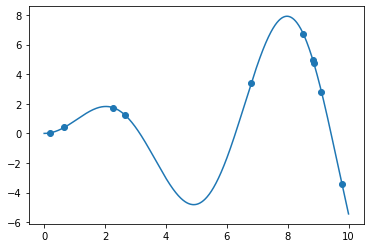

In [5]:
plt.plot(X,y)
plt.scatter(x_train, y_train)

In [35]:
# kernel = 1 * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=0.5)
# kernel = ConstantKernel() * RBF(1, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(0.1, (1e-9, 1e5))
kernel = ConstantKernel() * NTK(depth=2, c=2.0) + WhiteKernel(0.1)
gp = GPR(kernel=kernel, n_restarts_optimizer=9)
gp.fit(x_train, y_train)
gp.kernel_

(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)
(10, 1) (10, 1) (10, 10)


0.236**2 * NTK(depth=2, c=2.000) + WhiteKernel(noise_level=7.69)

In [36]:
mean_pred, std_pred = gp.predict(X, return_std=True)

(1000, 1) (10, 1)
(1010, 1)
(1010, 1) (1010, 1) (1010, 1010)
(2, 1010, 1010)
Returned (1000, 10)


/tmp/ipykernel_18254/2879064464.py:41: RuntimeWarning: invalid value encountered in true_divide
  λ = np.clip(Σ / D, a_min = - 1, a_max = 1)


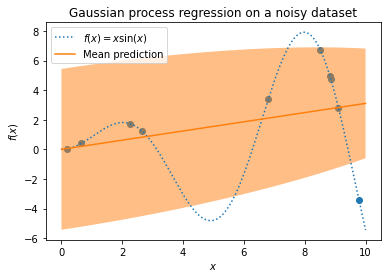

In [39]:
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(x=x_train.ravel(), y=y_train.ravel())
plt.plot(X, mean_pred, label="Mean prediction")
plt.fill_between(
    X.ravel(), 
    mean_pred.ravel() - 1.96*std_pred.ravel(), 
    mean_pred.ravel() + 1.96*std_pred.ravel(),
    alpha=0.5)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on a noisy dataset")

In [10]:
laplace_kernel = Matern(
    length_scale=1.0,
    length_scale_bounds=(1e-5, 1e5),
    nu=1/2
    )

